# Guitar-note-recognition

### Exploring how one can recognize guitar notes by signal processing

In [17]:
# Initializing a few packages

from IPython.display import Image
from IPython.core.display import HTML

import numpy as np
import matplotlib.pyplot as plt
import scipy as scipy
import math
from scipy.signal import stft
from scipy.signal import find_peaks
import wave


plt.rcParams.update({'font.size': 18})

### Introduction

As a guitarist one often wants to learn other songs. However, sometimes it can be hard to pinpoint the exact tone being played and sometimes one just does not want to bother. This computational essay will try to analyze the fundamental frequencies of a sound recording, focusing in particular on guitar recordings. We want to see how we can do signal analysis to determine the notes being played and how accurate it is. 

### Theory

##### What is a guitar note?

When you pluck a guitar string, you determine the initial shape (displacement) ($f(x)$) and velocity of the string ($g(x)$). Furthermore, we assume a one dimensional string that is stationary at it's ends. The vibration of the string is governed by the one‐dimensional wave-equation (Vistnes, A. I. (2015)):

$$
\begin{cases}
    u_{tt}(x,t) = c^2 u_{xx}(x,t), & 0 < x < L, \quad t > 0 \\[8pt]
    u(0,t) = u(L,t) = 0, & t \geq 0 \\[8pt]
    u(x,0) = f(x), & 0 \leq x \leq L \\[8pt]
    u_t(x,0) = g(x), & 0 \leq x \leq L
\end{cases}
$$

Furthermore, we know that the solution to the wave-equation is equivalent to an infinite sum of eigenfunctions.

$$
u(x,t) = \sum_{n=1}^{\infty} A_n \sin\left(\frac{n\pi x}{L}\right) \cos\left(\frac{n\pi c\,t}{L}\right)
$$

This is in music theory known as overtones or harmonics. We have the dominant frequency for $n = 1$, but the solution is not a single wave and thus we get a frequency-spectrum. However, what can become tricky is that the dominant frequency is not nescessary the tone we observe. We thus have to analyze the spectrum and find the best match. We also note that in nature there undertones do not appear. However, the vibration of a string can make another string vibrate sympathetically in a lower frequency which we will pick up as undertones. This makes our search more difficult. However, we will cut off all frequencies lower than E2 so we do not have to bother.


##### Implementing the Fourier transform:

The signal we recieve will be a wave file. At first we will try to analyze each frames frequencies. To do so we must take the signal from the time domain into the frequency domain. This can be done by utilizing a version of a fourier-transform, in our case we will use the fast Fourier transform (FFT). This is done on different time windows to analyze the spectrum of each note. We then search for frequency-peaks and see how well they match with the expected overtones of a given note. We will see that this works for clean signals, but will however not be ideal for noisy signals and also requires much more computational power.

##### Identifying the note

Musical notes are based on the distance to a reference pitch, which most often in Western music is A4 with $f_{\text{A4}} = 440\,\text{Hz}$. Furthermore, Western music also utilizes 12-tone equal temperament meaning that each octave is divided into 12 steps "(...) such that the ratio of the frequencies of any adjacent pair of notes is the same."  https://en.wikipedia.org/wiki/Equal_temperament

This means that for each note $n$, where $n=0$ is A4, we have:

$$
f_{n} = 440\cdot 2^{\frac{n}{12}} \,\text{Hz}
$$
giving us that 

$$
n = 12\cdot \log_{2}\left(\frac{f_n}{440\,\text{Hz}}\right)
$$

However, this introduces a problem as the guitar is not tuned to perfect equal temperament and will not be perfectly tuned to $f_\text{A4} = 440\,\text{Hz}$ either. Instead a guitar will be compromised due to fixed frets. So down the neck the frets are spaced to follow the 12-tone formula. However, the frets spaced equally for each string which gives error as each string has a slightly different ideal placement. https://acousticguitar.com/why-your-guitar-wont-play-perfectly-in-tune-and-why-thats-ok/

We will however assume tempered tuning using the midi-standard in the beginning and modify if we see that it is nescessary. 



##### Measuring time and frequency sharply

When doing numerical Fourier-transforms to analyze frequency spectra we must compromise in the accuracy we can measure the frequency and the resolution in time-window. If we choose large time windows we can find an accurate frequency, but if we get multiple fundamental frequencies in the same time-window we can not pick up on that they are different in an easy way. To resolve this we can do a quadratic interpolation. This fits a parabola through the magnitude spectrum around a detected peak to find a theoretical maxima/minima. This will also be utilized in the YIN-method, but this will be explained further down.

##### When does a new tone begin?

To determine when a new tone has begun we can simply look at when we get a new pitch matching another note. However, for the guitar this is not ideal as a new pitch can come from bending, sliding or even vibrato. We also have the clear problem that the same note can be strummed twice. Thus, as we might want to detect different techniques we lay the groundwork to detect new strums differently. We therefore use what is called the short-time energy (Rabiner & Schafer, 1978):

$$
E(n) = \Sigma^{M-1}_{m=0}|x(nH + m)|^2
$$

This intends to look at measure the localized energy across time windows. By setting a certain threshold, we can then determine what will be the start of a new note/pluck.



### Method

#### Utilizing FFT

At first we will use fast Fourier transform to analyze our signal. We then split the wave-file into multiple windows, analyzing each one and looking at the frequency spectra. We then match it up to a theoretical spectra. We do so by identifying the different frequency tops and then making these candidates.

For each candidate we find the overtones and then take the amplitude in the frequency-spectrum of the window for these overtones and add them. This gives us a score and we identify the highest score as the most likely candidate.

#### The YIN Algorithm

This project will implement the YIN-algorithm to estimate the fundamental frequency (proposed by A. de Cheveigné and H. Kawahara, "YIN, a fundamental frequency estimator for speech and sounds", JASA, 2002). This is as it is much better at handling noisy signals without using to much computational power. This is as we do not have to perform a fourier transform at each window, but rather work directly in the time-domain and finding the fundamental period $\tau$. This may seem weird, but we must remember that $\tau$ and $f_0$ are proportional sizes. Furthermore, our ears can detect a fundamental frequency even if it is not present in the signal, however the fundamental period will remain the same. The outline of the YIN method is as follows:

1. Find the Square Difference Function

We let $x$ denote a given frame at time $t$ and we want to find a difference function $d_t(\tau)$. It should measure the difference of the signal from a shifted version by a lag $\tau$. We also have a window size as explained above given as $W$

$$
d_t(\tau) =\Sigma_{j=1}^{W}\left[x_j - x_{j+\tau}\right]^2
$$

As mentioned $d_t(\tau)$ measures how dissimilar the signal is from a delayed version of itself. What we want to do is find a small value of $d_t(\tau)$ so that we know that $\tau$ is the fundamental period.

2. Normalizing with the Cumulative Mean

As mentioned the amplitude of the signal will vary greatly across our period $\tau$ and thus we may not pick up the actual $\tau$ that minimizes the square difference function. The YIN-algorithm introduces a cumulative mean normalized difference function to handle this. It is given as follows:

$$
\tilde{d}_t(\tau) = 
\begin{cases}
1,\quad \text{if} \,\,\tau = 0 \\
\frac{d_t(\tau)}{\left[\frac{1}{\tau}\Sigma_{j=1}^{\tau}d_t{(j)}\right]} \quad \text{otherwise}
\end{cases}
$$

What this does is that it attempts to normalize the function so that $\tilde{d}_t(\tau)\approx 1$ for lags where there is no clear periodic structure and thus not a present true fundamental period. When we have that $\tau$ is the fundamental period we will however get a dip below 1.

3. Thresholding

Sometimes we get deep dips that could be disguised as the the fundamental period dip, these are often the subharmonics due to how the difference function searches for $\tau$ as the overtones do not have the same periodic similarity. To avoid these subharmonic errors we introduce a threshold as the fundamental period dip will often be greater. For our purpose we choose a threshold of 0.1. So what we now search for is to find the $\tau$ that minimizes $\tilde{d}_t(\tau)$ with the constraint that $\tilde{d}_t(\tau)<0.1$. If no $\tau$ confers with this we will say that no fundamental frequency is detected.

4. Parabolic Interpolation

As explained above we can not measure time and frequency sharply without affecting the other accuracy. So even though we find our $\tau$, if it is not a multiple of the sampling period we can be incorrect by up to a half of this value. Thus, we will also here introduce a parabolic interpolation to estimate the actual $\tau$. So whenever we find a minima for $\tilde{d}_t(\tau)$ we make a parabolic fit around it's neighbours and find the theoretical minima of the interpolation.


#### Choosing parameters

If we have a sample rate of $f_s$ we need to choose window size accordingly. The YIN-method looks at the periodicity of signals and if our time-window $W$ is too short it will not be able to pick up enough periods to be able to determine that it is the fundamental period. So, we expect a minimum frequency of $E2 = 82.41\,\text{Hz}$. This gives us a period of $T_{E2} = \frac{1}{82.41}\,\text{s} \approx 0.012\,\text{s}$ so our windows must be atleast this large. However, just one period will not be sufficient as this does not show a clear pattern. Therefore we must choose a sufficient frame size $W$, so that $\frac{W}{f_s}>T_{E2}$. However, increasing this size means that we get a lower time resolution, we will therefore find a comprimise by experimentally checking.

Below is an example of a pure E2-signal over different windows.

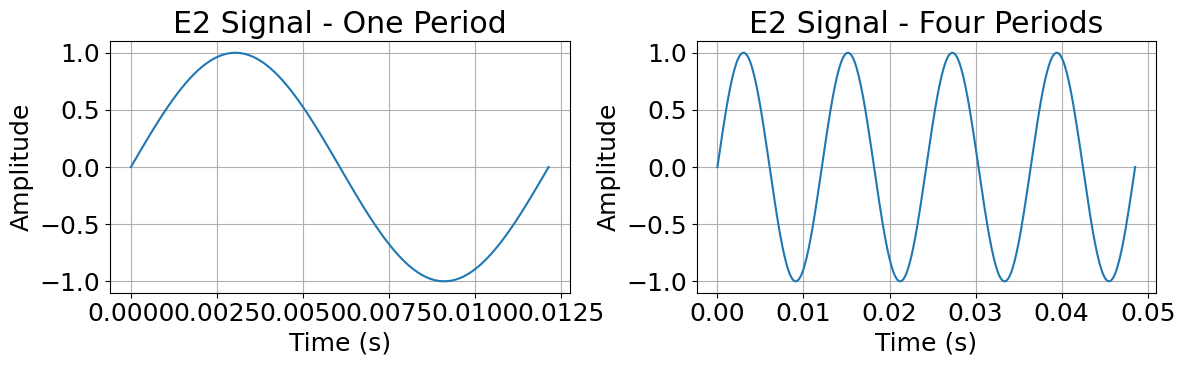

In [18]:


# Define E2 note frequency (Hz)
f_E2 = 82.41  

# Define time periods
T = 1 / f_E2  # One period
t1 = np.linspace(0, T, 100)  # Time array for one period
t2 = np.linspace(0, 4*T, 400)  # Time array for two periods

# Generate the sine wave for E2
signal1 = np.sin(2 * np.pi * f_E2 * t1)
signal2 = np.sin(2 * np.pi * f_E2 * t2)

# Plot the signals
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Left plot (One period)
axes[0].plot(t1, signal1)
axes[0].set_title("E2 Signal - One Period")
axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("Amplitude")
axes[0].grid()

# Right plot (Four periods)
axes[1].plot(t2, signal2)
axes[1].set_title("E2 Signal - Four Periods")
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Amplitude")
axes[1].grid()

plt.tight_layout()
plt.show()


Furthermore, we also have hop size determining where to start our next window. To get the least possible loss we choose a 50\% overlap. Meaning that the hop size should be half the window size.

### Implementation/Pseudocode


1. **Import Audio Data**  
   - Open the WAV file  
   - Extract the sample rate and audio samples  
   - Convert stereo to mono

2. **Divide the Audio into Time Windows**  
   - Choose a frame size (number of samples per window)  
   - Choose a hop size (overlap between windows)  
   - Apply a Hann or similar window function to each frame

3. **Fourier Transform Analysis (FFT Method)**  
   - For each time window:  
      - Do a STFT to get spectrum
      - Refine the frequency estimate using quadratic interpolation  
      - Find the dominant frequencies (peaks)
      - Map the refined frequency to a candidate guitar note using a note dictionary and expected spectrum

4. **Fundamental Frequency Detection with the YIN Algorithm**  
   - For each time window:  
     - Compute the squared difference function for various lags (τ)  
     - Calculate the cumulative mean normalized difference function  
     - Identify the first τ where the normalized value falls below a set threshold  
     - Refine the τ value with quadratic interpolation  
     - Convert the refined τ (period) into the fundamental frequency (f₀)

5. **Map Frequencies to Musical Notes**  
   - Convert frequencies to MIDI note numbers
   - Translate MIDI numbers into note names


7. **Note Onset Detection Using Short-Time Energy**  
   - Calculate the short-time energy of each time window (sum of squared amplitudes)  
   - Compare energy and pitch changes between consecutive windows  
   - Mark time stamps where significant energy or pitch changes occur as potential note onsets



### Results & Code

At first we want to introduce a function that can read wavefiles. It should also make sure that our signal is in mono, to ease the processin (also as the Beatles is best in mono).

In [19]:
def read_wav(file_path):
    """
    Reads a WAV file and returns the sample rate and audio data as a NumPy array.
    Handles both mono and stereo files by converting stereo to mono.
    """
    with wave.open(file_path, 'rb') as wav_file:
        sample_rate = wav_file.getframerate()
        num_frames = wav_file.getnframes()
        num_channels = wav_file.getnchannels()  # Check if the file is mono or stereo
        audio_data = np.frombuffer(wav_file.readframes(num_frames), dtype=np.int16)

    # If stereo, convert to mono by averaging channels
    if num_channels == 2:
        try:
            audio_data = audio_data.reshape(-1, 2)
        except ValueError:
            print(f"Warning: Odd number of samples detected ({len(audio_data)}), truncating last sample.")
            audio_data = audio_data[:len(audio_data) - 1].reshape(-1, 2)
        
        audio_data = audio_data.mean(axis=1).astype(np.int16)  # Convert to mono

    
    return sample_rate, audio_data


To test our function further down we also want to test with a simple sine-wave of frequency 440 Hz.

In [20]:
### Generate example file

def generate_sine_wave(frequency=440, duration=2, sample_rate=44100, amplitude=32767):
    """
    Generates a sine wave and saves it as a WAV file.

    Parameters:
    - frequency: Frequency of the sine wave in Hz (default 440 Hz for A4).
    - duration: Duration of the generated wave in seconds (default 2 seconds).
    - sample_rate: Sampling rate in Hz (default 44100 Hz).
    - amplitude: Amplitude of the wave (default 32767 for 16-bit PCM audio).

    Returns:
    - File path of the generated WAV file.
    """
    t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
    waveform = (amplitude * np.sin(2 * np.pi * frequency * t)).astype(np.int16)

    file_path = f"C:/Users/victo/Documents/Github/GuitarRecognition/data/example_{frequency}Hz.wav"
    with wave.open(file_path, "w") as wav_file:
        wav_file.setnchannels(1)  # Mono
        wav_file.setsampwidth(2)  # 16-bit PCM
        wav_file.setframerate(sample_rate)
        wav_file.writeframes(waveform.tobytes())

    return file_path


We create a dictionary with the note-names and the frets. This is not used very much, but we may use it in later work. 

In [21]:
# Define the mapping of semitone index to note name (using sharps)
NOTE_NAMES = ['A', 'A#', 'B', 'C', 'C#', 'D', 
              'D#', 'E', 'F', 'F#', 'G', 'G#']

def note_to_offset(note):
    """
    Given a note name, calculate the semitone offset from A4 (440 Hz).
    """
    # Determine if the note has an accidental (sharp)
    if len(note) >= 3 and note[1] == '#':
        pitch = note[:-1]  # e.g., 'C#'
        octave = int(note[-1])
    else:
        pitch = note[0]    # e.g., 'E'
        octave = int(note[1:])
        
    # Get raw index from NOTE_NAMES
    raw_index = NOTE_NAMES.index(pitch)
    
    # Adjust for octave: notes C and above are considered part of the next octave in this scheme
    if raw_index >= NOTE_NAMES.index("C"):
        semitone_adjust = raw_index - 12
    else:
        semitone_adjust = raw_index
        
    offset = (octave - 4) * 12 + semitone_adjust
    return offset

def offset_to_note(offset):
    """
    Convert a semitone offset (relative to A4) into its note name (e.g., 'C4').
    This version uses the MIDI note number for correct octave handling.
    """
    midi = offset + 69  # MIDI note number for A4 is 69
    note_name = NOTE_NAMES[(midi - 9) % 12]  # Adjust index so that MIDI 69 maps to 'A'
    octave = (midi // 12) - 1
    return f"{note_name}{octave}"

def offset_to_freq(offset):
    """
    Convert a semitone offset (relative to A4) into frequency in Hz.
    """
    return 440 * 2**(offset/12)

# Number of frets on the guitar (Gibson Les Paul)
num_frets = 24

# Standard tuning for a 6-string guitar (string number : open note)
tuning = {
    6: "E2",
    5: "A2",
    4: "D3",
    3: "G3",
    2: "B3",
    1: "E4"
}

# Dictionary to store the computed notes and frequencies for each string.
# The structure: guitar_notes[string_number] = [(fret, note_name, frequency), ...]
guitar_notes = {}

for string, open_note in tuning.items():
    open_offset = note_to_offset(open_note)
    notes_for_string = []
    for fret in range(num_frets + 1):
        current_offset = open_offset + fret
        note_name = offset_to_note(current_offset)
        freq = offset_to_freq(current_offset)
        notes_for_string.append((fret, note_name, freq))
    guitar_notes[string] = notes_for_string


Now, we begin the STFT-analysis.

In [22]:
def analyze_stft(file_path, window_size=2048, hop_size=1024, window_type='hann'):
    """
    Reads an audio file, computes its short-time Fourier transform (STFT), 
    and identifies the dominant frequency in each time frame.
    
    Parameters:
    - file_path: Path to the WAV file.
    - window_size: Number of samples per window.
    - hop_size: Number of samples between successive windows.
    - window_type: Type of window to apply (default 'hann').
    
    Returns:
    - times: Array of time bins corresponding to each STFT window.
    - dominant_frequencies: Array of dominant frequency (in Hz) per time frame.
    - f: Frequency bins from the STFT.
    - Zxx: STFT complex spectrum.
    """
    # Read the audio file.
    sample_rate, audio_data = read_wav(file_path)
    
    # Compute the STFT.
    f, t, Zxx = stft(audio_data, fs=sample_rate, window='hann', nperseg=window_size, noverlap=window_size-hop_size)
    
    # For each time slice, find the frequency with maximum magnitude.
    dominant_frequencies = []
    for i in range(Zxx.shape[1]):
        # Consider only positive frequencies by default (f is positive when fs > 0)
        magnitudes = np.abs(Zxx[:, i])
        idx = np.argmax(magnitudes)
        dominant_frequencies.append(f[idx])
        
    return t, np.array(dominant_frequencies), f, Zxx




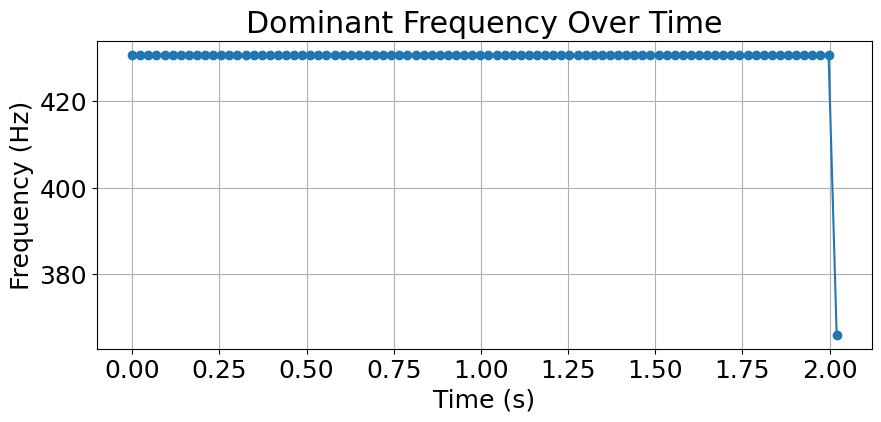

In [23]:
file_path = generate_sine_wave()

# Analyze the audio file using STFT.
times, dominant_frequencies, f, Zxx = analyze_stft(file_path)

# Plot the dominant frequency over time.
plt.figure(figsize=(10, 4))
plt.plot(times, dominant_frequencies, marker='o', linestyle='-')
plt.title("Dominant Frequency Over Time")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.grid(True)
plt.show()

We see that we get 430 Hz even though we put in a generated sine wave with frequency of 440 Hz. This is from the bin size. However, reducing this means that we get greater time-intervals which means that we possibly can not pick up everything. So we now want to introduce an interpolation. We also see that it falls rapidly at the end. To fix this, we need to not include the endpoints.

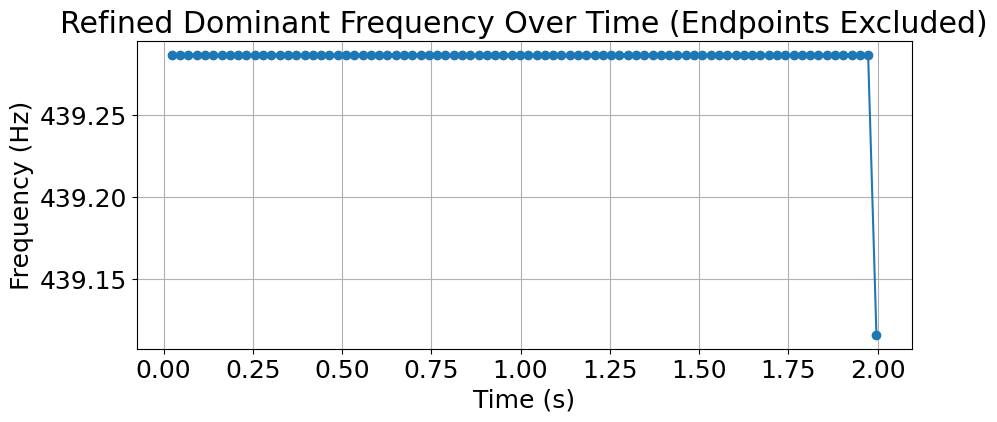

In [24]:
def quadratic_interpolation(magnitudes, peak_idx, bin_width):
    """
    Applies quadratic interpolation around the peak bin to refine the frequency estimate.

    Parameters:
    - magnitudes: Array of magnitudes for frequency bins.
    - peak_idx: Index of the maximum magnitude (peak) in the array.
    - bin_width: The frequency spacing between bins in Hz.

    Returns:
    - Correction (in Hz) to be added to the frequency at peak_idx.
    """
    if peak_idx <= 0 or peak_idx >= len(magnitudes) - 1:
        return 0.0
    # Magnitudes of the peak and its immediate neighbors
    alpha = magnitudes[peak_idx - 1]
    beta = magnitudes[peak_idx]
    gamma = magnitudes[peak_idx + 1]
    
    # Compute the correction factor (delta) based on the parabolic fit
    denominator = alpha - 2 * beta + gamma
    if denominator == 0:
        delta = 0
    else:
        delta = 0.5 * (alpha - gamma) / denominator
    return delta * bin_width

def analyze_stft_interpolated(file_path, window_size=2048, hop_size=1024, window_type='hann'):
    """
    Reads an audio file, computes its STFT, and identifies the refined dominant frequency 
    in each time frame using quadratic interpolation while skipping the endpoints.

    Parameters:
    - file_path: Path to the WAV file.
    - window_size: Number of samples per window.
    - hop_size: Number of samples between successive windows.
    - window_type: Type of window to apply.

    Returns:
    - times: Array of time bins (excluding the first and last frames).
    - interpolated_frequencies: Array of refined dominant frequency (in Hz) per time frame.
    - f: Frequency bins from the STFT.
    - Zxx: STFT complex spectrum.
    """
    # Read the audio file.
    sample_rate, audio_data = read_wav(file_path)
    
    # Compute the STFT.
    f, t, Zxx = stft(audio_data, fs=sample_rate, window=window_type, 
                       nperseg=window_size, noverlap=window_size-hop_size)
    
    # Frequency bin width in Hz (assuming uniform spacing)
    bin_width = f[1] - f[0] if len(f) > 1 else 0
    
    interpolated_frequencies = []
    refined_times = []
    
    # Exclude the first and last time frames to avoid edge artifacts.
    for i in range(1, Zxx.shape[1] - 1):
        magnitudes = np.abs(Zxx[:, i])
        peak_idx = np.argmax(magnitudes)
        # Basic frequency estimate from the peak index.
        basic_freq = f[peak_idx]
        # Calculate correction using quadratic interpolation.
        correction = quadratic_interpolation(magnitudes, peak_idx, bin_width)
        refined_freq = basic_freq + correction
        interpolated_frequencies.append(refined_freq)
        refined_times.append(t[i])
        
    return np.array(refined_times), np.array(interpolated_frequencies), f, Zxx

# Analyze the audio file using STFT with quadratic interpolation.
times, interpolated_frequencies, f, Zxx = analyze_stft_interpolated(file_path, window_size=2048, hop_size=1024)

# Plot the refined dominant frequency over time.
plt.figure(figsize=(10, 4))
plt.plot(times, interpolated_frequencies, marker='o', linestyle='-')
plt.title("Refined Dominant Frequency Over Time (Endpoints Excluded)")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.grid(True)
plt.show()


Here, we can clearly see that it is closer to 440Hz, which is the actual frequency.

Now, we want to look at a clean C3 sound (https://freewavesamples.com/alesis-fusion-clean-guitar-c3). We want to analyze the harmonic spectrum and find some peaks.

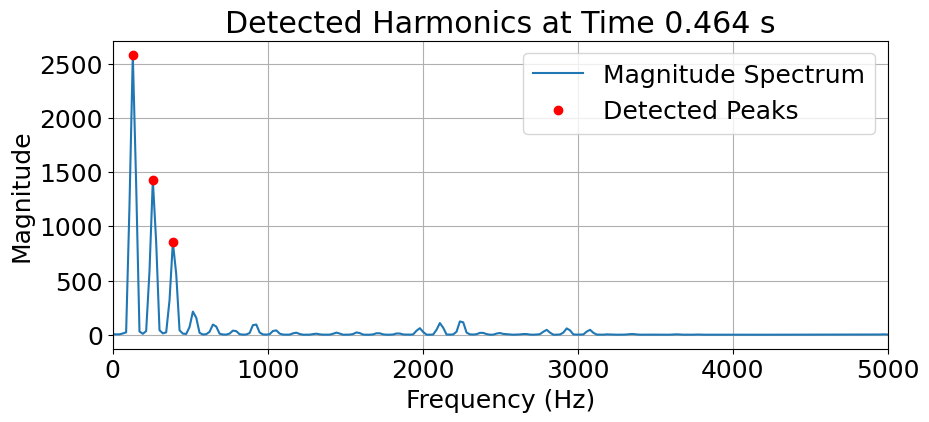

array([130.07342704, 260.45609613, 390.79122348])

In [25]:
def analyze_harmonics(file_path, window_size=2048, hop_size=1024, window_type='hann', 
                        peak_prominence=200):
    """
    Reads an audio file, computes its STFT, and identifies multiple peaks (harmonics)
    in each time frame using a peak detection algorithm.

    Parameters:
    - file_path: Path to the WAV file.
    - window_size: Number of samples per window.
    - hop_size: Number of samples between successive windows.
    - window_type: Type of window to apply (default 'hann').
    - peak_prominence: Minimum prominence of peaks to consider (adjust based on signal amplitude).

    Returns:
    - times: Array of time bins corresponding to each STFT window.
    - harmonics_per_frame: List where each element corresponds to a time frame and contains a
      tuple of (refined_peak_frequencies, peak_magnitudes).
    - f: Frequency bins from the STFT.
    - Zxx: STFT complex spectrum.
    """
    # Read the audio file.
    sample_rate, audio_data = read_wav(file_path)
    
    # Compute the STFT.

    f, t, Zxx = stft(audio_data, fs=sample_rate, window=window_type, 
                       nperseg=window_size, noverlap=(window_size- hop_size))
    bin_width = f[1] - f[0] if len(f) > 1 else 0

    harmonics_per_frame = []
    
    # Process each time frame.
    for i in range(Zxx.shape[1]):
        magnitudes = np.abs(Zxx[:, i])
        
        # Set a minimum threshold relative to the maximum magnitude in the frame.
        min_threshold = 0.1 * np.max(magnitudes)
        
        # Detect peaks in the magnitude spectrum with an added condition on minimum magnitude.
        peaks, properties = find_peaks(magnitudes, prominence=peak_prominence)
        
        # Filter out peaks that do not meet the minimum threshold.
        valid_peaks = peaks[magnitudes[peaks] >= min_threshold]
        peak_mags = magnitudes[valid_peaks]
        
        # Refine each detected peak using quadratic interpolation.
        refined_freqs = []
        for peak_idx in valid_peaks:
            if 0 < peak_idx < len(magnitudes) - 1:
                basic_freq = f[peak_idx]
                correction = quadratic_interpolation(magnitudes, peak_idx, bin_width)
                refined_freq = basic_freq + correction
            else:
                refined_freq = f[peak_idx]
            refined_freqs.append(refined_freq)
        
        harmonics_per_frame.append((np.array(refined_freqs), peak_mags))

    
    return t, harmonics_per_frame, f, Zxx

# Example usage:
file_path = "C:/Users/victo/Documents/Github/GuitarRecognition/data/Alesis-Fusion-Clean-Guitar-C3.wav"
times, harmonics, f, Zxx = analyze_harmonics(file_path)


# Choose a specific time frame index to visualize (for example, index 10)
frame_idx = 20
detected_freqs, detected_mags = harmonics[frame_idx]

plt.figure(figsize=(10, 4))
plt.plot(f, np.abs(Zxx[:, frame_idx]), label='Magnitude Spectrum')
plt.plot(detected_freqs, detected_mags, 'ro', label='Detected Peaks')
plt.xlim(0, 5000)  # Only plot frequencies up to 5000 Hz
plt.title(f"Detected Harmonics at Time {times[frame_idx]:.3f} s")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.legend()
plt.grid(True)
plt.show()

detected_freqs

Here, we see we have three peaks in the spectrum at 130, 260 and 391 Hz. Which is expected for the C3, from the solutions of the wave function.

In [26]:
def find_note(detected_freqs, guitar_notes):
    """
    Matches detected frequencies to guitar note names using a guitar_notes dictionary.
    
    This function accepts a single frequency (int or float), a list, or a NumPy array.
    It flattens the guitar_notes dictionary into candidate (note_name, frequency) pairs,
    and for each detected frequency finds the candidate note with the smallest absolute
    frequency difference. The best match is always returned by rounding to the nearest candidate.
    
    Parameters:
    - detected_freqs: A single frequency (int/float) or an array-like of frequencies.
    - guitar_notes: Dictionary mapping each string to a list of tuples (fret, note_name, frequency).
    
    Returns:
    - List of matched note names for each input frequency.
    """
    # Flatten the guitar_notes dictionary into candidate (note_name, frequency) pairs.
    candidate_notes = []
    for string, notes_list in guitar_notes.items():
        for fret, note_name, freq in notes_list:
            candidate_notes.append((note_name, freq))
    
    # If detected_freqs is a single number, wrap it in a list.
    if not hasattr(detected_freqs, '__iter__'):
        detected_freqs = [detected_freqs]
    
    matched_notes = []
    for freq in detected_freqs:
        best_note = None
        min_diff = float('inf')
        for note_name, candidate_freq in candidate_notes:
            diff = abs(freq - candidate_freq)
            if diff < min_diff:
                min_diff = diff
                best_note = note_name
        matched_notes.append(best_note)
            
    return matched_notes

# Example usage:
# Assume detected_freqs is either a single frequency or an array of frequencies,
# and guitar_notes is your dictionary mapping each string to note details.
candidates = find_note(detected_freqs, guitar_notes)
print(candidates)

['C3', 'C4', 'G4']


If you were unsure, here you can see it more cleary. We have the C3, the octave over and the dominat fifth which is exactly what the theory tells us.

In [27]:
def match_candidate_to_spectrum(candidate_freq, f, spectrum, num_harmonics=5, tolerance=5):
    """
    Computes a match score for a candidate note based on its expected harmonic series.

    Parameters:
    - candidate_freq: Fundamental frequency (Hz) of the candidate note.
    - f: Array of frequency bins from the STFT.
    - spectrum: Amplitude spectrum for a given time frame.
    - num_harmonics: Number of harmonics to consider (default 5).
    - tolerance: Tolerance in Hz to decide if a spectral peak is close enough to the expected harmonic.

    Returns:
    - match_score: A score reflecting how well the candidate's harmonics are represented.
    """
    match_score = 0.0
    for harmonic in range(1, num_harmonics + 1):
        expected_freq = candidate_freq * harmonic
        # Find the frequency bin closest to the expected harmonic.
        idx = np.argmin(np.abs(f - expected_freq))
        # If the difference is within the tolerance, add the amplitude to the score.
        if np.abs(f[idx] - expected_freq) < tolerance:
            match_score += spectrum[idx]
    return match_score

def best_match_from_candidates(candidates, f, spectrum, tolerance=5, num_harmonics=5):
    """
    Selects the candidate note that best fits the measured spectrum by comparing
    the energy in its expected harmonic frequencies.

    Parameters:
    - candidates: List of candidate note names (e.g., ['C3', 'E3']).
    - f: Array of frequency bins from the STFT.
    - spectrum: Amplitude spectrum for the chosen time frame.
    - tolerance: Frequency tolerance in Hz (default 5 Hz).
    - num_harmonics: Number of harmonics to consider for the matching score.

    Returns:
    - best_candidate: The candidate note name with the highest match score.
    - best_score: The corresponding match score.
    """
    best_score = -np.inf
    best_candidate = None

    for candidate in candidates:
        # Compute the fundamental frequency from the candidate note.
        offset = note_to_offset(candidate)
        candidate_freq = offset_to_freq(offset)
        score = match_candidate_to_spectrum(candidate_freq, f, spectrum, num_harmonics, tolerance)
        print(f"Candidate {candidate} (f0 = {candidate_freq:.2f} Hz) match score: {score:.2f}")
        if score > best_score:
            best_score = score
            best_candidate = candidate

    return best_candidate, best_score

# Example usage:
frame_idx = 50  # A random time frame

# Extract the amplitude spectrum for that frame.
spectrum_frame = np.abs(Zxx[:, frame_idx])

candidates = find_note(detected_freqs, guitar_notes)

best_candidate, best_score = best_match_from_candidates(candidates, f, spectrum_frame)
print(f"\nBest candidate note: {best_candidate} with score: {best_score:.2f}")




Candidate C3 (f0 = 130.81 Hz) match score: 1750.18
Candidate C4 (f0 = 261.63 Hz) match score: 447.54
Candidate G4 (f0 = 392.00 Hz) match score: 409.58

Best candidate note: C3 with score: 1750.18


We see that it accuractely detects a C3-note as the most probable, which is what we gave it. Now, we will look at a window after the tone has rung a bit in my recorded guitar of an E2-note.

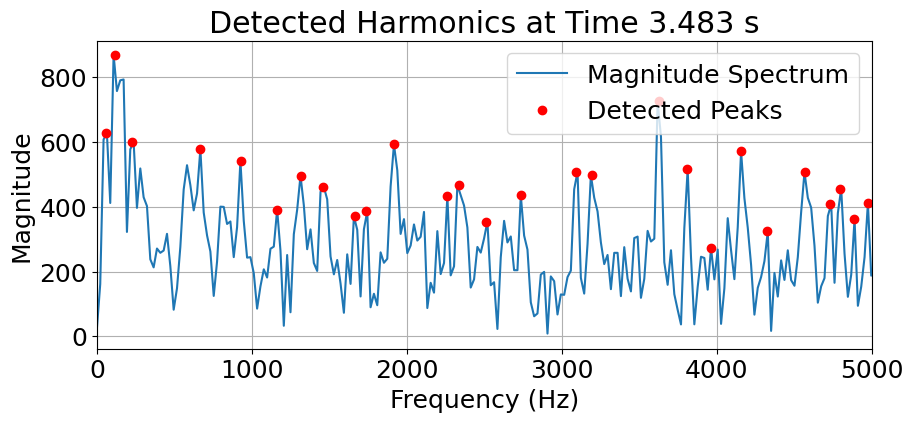

In [28]:
file_path = "C:/Users/victo/Documents/Github/GuitarRecognition/data/guitar_lp_E.wav"
times, harmonics, f, Zxx = analyze_harmonics(file_path)


# Choose a specific time frame index to visualize 
frame_idx = 150
detected_freqs, detected_mags = harmonics[frame_idx]

plt.figure(figsize=(10, 4))
plt.plot(f, np.abs(Zxx[:, frame_idx]), label='Magnitude Spectrum')
plt.plot(detected_freqs, detected_mags, 'ro', label='Detected Peaks')
plt.xlim(0, 5000)  # Only plot frequencies up to 5000 Hz
plt.title(f"Detected Harmonics at Time {times[frame_idx]:.3f} s")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.legend()
plt.grid(True)
plt.show()

We see that this is a much more noisy signal. I will not analyze this to not fill up too much space, but as you can imagine it will prompt inaccurate results. So now, we use the YIN-algorithm.

In [29]:
def yin_pitch(frame, sample_rate, fmin=50, fmax=1000, threshold=0.1):
    """
    Estimates the fundamental frequency of a given audio frame using the YIN algorithm.
    
    Parameters:
    - frame: 1D NumPy array containing a segment of audio samples.
    - sample_rate: Sampling rate of the audio (Hz).
    - fmin: Minimum expected frequency (Hz); determines the maximum period.
    - fmax: Maximum expected frequency (Hz); determines the minimum period.
    - threshold: Threshold for the normalized difference function to detect the pitch.
    
    Returns:
    - f0: Estimated fundamental frequency (Hz). Returns 0 if no pitch is detected.
    """
    # Determine lag range based on fmin and fmax.
    tau_min = int(np.floor(sample_rate / fmax))
    tau_max = int(np.floor(sample_rate / fmin))
    tau_max = min(tau_max, len(frame))

    # Step 1: Compute squared difference function d(τ).
    d = np.zeros(tau_max)
    for tau in range(tau_min, tau_max):
        d[tau] = np.sum((frame[:len(frame)-tau] - frame[tau:])**2)
    
    # Step 2: Compute cumulative mean normalized difference function d'(τ).
    d_tilde = np.zeros(tau_max)
    d_tilde[0] = 1  # Defined as 1 for τ=0
    running_sum = 0.0
    for tau in range(1, tau_max):
        running_sum += d[tau]
        d_tilde[tau] = d[tau] * tau / (running_sum if running_sum > 0 else 1)
    
    # Step 3: Find the first τ where d'(τ) falls below the threshold.
    tau_est = None
    for tau in range(tau_min, tau_max):
        if d_tilde[tau] < threshold:
            # Move to the local minimum to avoid subharmonic errors.
            while tau + 1 < tau_max and d_tilde[tau + 1] < d_tilde[tau]:
                tau += 1
            tau_est = tau
            break

    if tau_est is None:
        # No pitch detected in this frame.
        return 0

    # Step 4: Quadratic interpolation for a refined estimate.
    if tau_est <= 0 or tau_est >= tau_max - 1:
        refined_tau = tau_est
    else:
        alpha = d_tilde[tau_est - 1]
        beta = d_tilde[tau_est]
        gamma = d_tilde[tau_est + 1]
        denominator = alpha - 2 * beta + gamma
        delta = 0.5 * (alpha - gamma) / denominator if denominator != 0 else 0
        refined_tau = tau_est + delta

    # Convert period (τ) to frequency.
    f0 = sample_rate / refined_tau if refined_tau > 0 else 0
    return f0

def yin_pitch_detection(signal, sample_rate, frame_size=2048, hop_size=1024, fmin=50, fmax=1000, threshold=0.1):
    """
    Processes an entire audio signal to estimate the fundamental frequency over time using the YIN algorithm.
    
    Parameters:
    - signal: 1D NumPy array of audio samples.
    - sample_rate: Sampling rate of the audio (Hz).
    - frame_size: Number of samples per frame.
    - hop_size: Number of samples to shift between successive frames.
    - fmin: Minimum expected frequency (Hz).
    - fmax: Maximum expected frequency (Hz).
    - threshold: Threshold for pitch detection in the YIN algorithm.
    
    Returns:
    - times: Array of time instants (s) corresponding to each frame.
    - pitches: Array of estimated fundamental frequencies (Hz) per frame.
    """
    num_frames = (len(signal) - frame_size) // hop_size + 1
    pitches = []
    times = np.arange(num_frames) * hop_size / sample_rate  # Accurate time stamps

    for i in range(num_frames):
        start = i * hop_size
        frame = signal[start:start+frame_size].astype(np.float32)
        # Apply a Hann window to reduce leakage (square window should work the same according to the theory from the paper)
        window = np.hanning(len(frame))
        frame_windowed = frame * window
        f0 = yin_pitch(frame_windowed, sample_rate, fmin, fmax, threshold)
        pitches.append(f0)
    return times, np.array(pitches)




Now, that we have initialized the YIN-algorithm, we look at a recording I made of a d-major-scale.

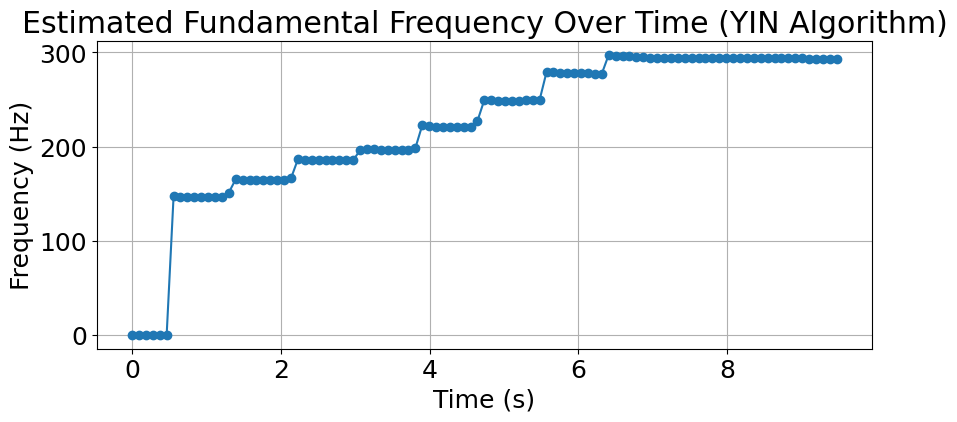

In [30]:
# Load the WAV file
file_path = "C:/Users/victo/Documents/Github/GuitarRecognition/data/d_major_scale.wav"

# Read the audio file
sample_rate, audio_data = read_wav(file_path)

# Run the YIN pitch detection.
frame_size = 8192
hop_size = frame_size // 2 # want 50% overlap of windows
fmin, fmax = 50, 10000
times, pitches = yin_pitch_detection(audio_data, sample_rate, frame_size, hop_size,
                                    fmin=fmin, fmax=fmax, threshold=0.2)

# Plot the estimated pitch over time.
plt.figure(figsize=(10, 4))
plt.plot(times, pitches, marker='o', linestyle='-')
plt.title("Estimated Fundamental Frequency Over Time (YIN Algorithm)")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.grid(True)
plt.show()



We see a nice increase that looks logical, however, this does not tell us too much unless you go around remembering frequencies for different notes. Thus, we turn the frequencies into MIDI.

In [31]:
def frequency_to_midi(frequency):
    """
    Converts a frequency in Hz to the nearest MIDI note number.
    Returns None for non-positive frequencies.
    """
    if frequency <= 0:
        return None
    midi = int(round(69 + 12 * math.log2(frequency / 440.0)))
    return midi

NOTE_NAMES = ['C', 'C#', 'D', 'D#', 'E', 'F', 
              'F#', 'G', 'G#', 'A', 'A#', 'B']

def midi_to_note_name(midi):
    """
    Converts a MIDI note number to its note name (e.g., 'C4').
    """
    note_index = (midi - 12) % 12
    octave = (midi // 12) - 1
    return f"{NOTE_NAMES[note_index]}{octave}"

def frequency_to_note_name(frequency):
    """
    Converts a frequency in Hz to the nearest note name.
    Returns "No pitch" for non-positive frequencies.
    """
    midi = frequency_to_midi(frequency)
    if midi is None:
        return "No pitch"
    return midi_to_note_name(midi)

# -------------------------
# Plotting Notes Over Time
# -------------------------

def plot_notes_over_time(times, pitches):
    """
    Plots detected notes over time by converting frequencies into MIDI numbers.
    The y-axis is labeled with the corresponding note names.
    """
    # Convert pitch frequencies to MIDI numbers; use NaN for frames with no pitch.
    midi_numbers = []
    for f in pitches:
        m = frequency_to_midi(f)
        midi_numbers.append(m if m is not None else np.nan)
    midi_numbers = np.array(midi_numbers)

    plt.figure(figsize=(10, 4))
    plt.scatter(times, midi_numbers, c='b', marker='o', label='Detected Note')
    plt.xlabel("Time (s)")
    plt.ylabel("MIDI Note Number")
    plt.title("Detected Musical Notes Over Time (YIN Algorithm)")
    plt.grid(True)
    
    # Set y-ticks to cover the range of detected notes.
    if np.any(~np.isnan(midi_numbers)):
        min_midi = int(np.nanmin(midi_numbers)) - 1
        max_midi = int(np.nanmax(midi_numbers)) + 1
        yticks = np.arange(min_midi, max_midi + 1)
        ytick_labels = [midi_to_note_name(m) for m in yticks]
        plt.yticks(yticks, ytick_labels)
    plt.legend()
    plt.show()




We then try for the D-major-scale again.

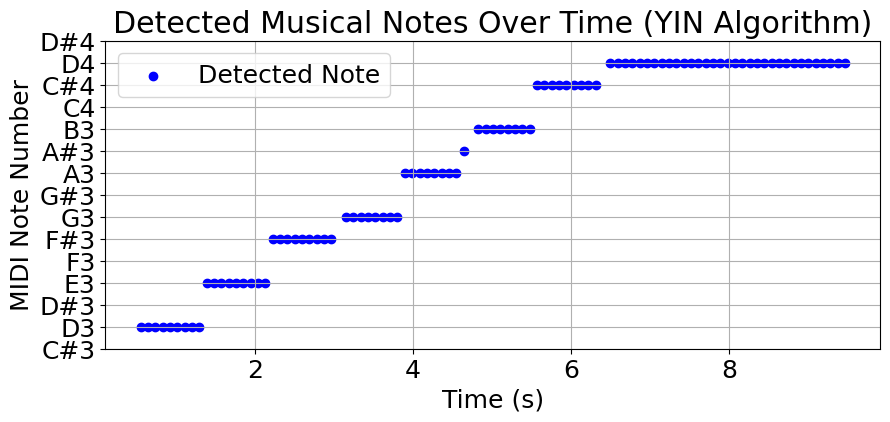

In [32]:
file_path = "C:/Users/victo/Documents/Github/GuitarRecognition/data/d_major_scale.wav"

# Read audio file.
sample_rate, audio_data = read_wav(file_path)

# Run YIN pitch detection.
frame_size = 8192
hop_size = frame_size // 2  # 50% overlap
fmin, fmax = 50, 10000
times, pitches = yin_pitch_detection(audio_data, sample_rate, frame_size, hop_size,
                                        fmin=fmin, fmax=fmax, threshold=0.1)

# Plot the notes over time instead of raw frequency.
plot_notes_over_time(times, pitches)

We see that this follows a D-major scale very accurately with just one deviation of A#3, however from listening to the recording it is clear that this is because of sloppy guitar-play. However, now we can only detect changes in frequency, not when a new note is played. So we try to implement short-time energy.

In [33]:
def compute_short_time_energy(signal, frame_size, hop_size):
    """
    Computes the short-time energy (STE) of the signal.
    
    Parameters:
    - signal: 1D numpy array of audio samples.
    - frame_size: Number of samples per frame.
    - hop_size: Number of samples to advance between frames.
    
    Returns:
    - energies: Array of energy values, one per frame.
    """
    num_frames = (len(signal) - frame_size) // hop_size + 1
    energies = np.empty(num_frames)
    for i in range(num_frames):
        start = i * hop_size
        frame = signal[start:start+frame_size]
        energies[i] = np.sum(frame.astype(float)**2)
    return energies

def detect_note_onsets(pitches, energies, times, 
                       pitch_change_threshold=20, 
                       energy_ratio_threshold=1.5, 
                       min_silence_frames=2):
    """
    Detects the onset of a new note by looking for significant changes
    in both the pitch (in Hz) and short-time energy.
    
    Parameters:
    - pitches: Array of estimated fundamental frequencies (Hz) per frame.
    - energies: Array of short-time energy values per frame.
    - times: Array of time stamps corresponding to each frame.
    - pitch_change_threshold: Minimum change in Hz to consider as a note change.
    - energy_ratio_threshold: Ratio by which energy must increase after a dip.
      (e.g., if energy drops and then increases by this factor, it is considered an onset).
    - min_silence_frames: Minimum number of consecutive frames with low energy to mark a note end.
    
    Returns:
    - onset_times: List of time instants (s) where a new note is detected.
    """
    onset_times = []
    num_frames = len(pitches)
    # Assume the very first frame is the beginning of a note.
    onset_times.append(times[0])
    
    # For tracking a potential dip (silence or low energy) between notes.
    low_energy = False
    silence_counter = 0
    
    for i in range(1, num_frames):
        # Calculate the absolute pitch difference from the previous frame.
        pitch_diff = abs(pitches[i] - pitches[i-1])
        
        # Check for a dip in energy (could indicate the end of a note).
        if energies[i] < energies[i-1] * 0.8:
            low_energy = True
            silence_counter += 1
        else:
            # If previously low energy and now there's a significant jump,
            # it could indicate the start of a new note.
            if low_energy and silence_counter >= min_silence_frames:
                # Ensure that the pitch change is also significant to avoid triggering on vibrato.
                if pitch_diff > pitch_change_threshold or energies[i] > energies[i-1] * energy_ratio_threshold:
                    onset_times.append(times[i])
                    low_energy = False
                    silence_counter = 0
            else:
                # If no clear low-energy period, a sudden large pitch change might indicate a new note.
                if pitch_diff > pitch_change_threshold:
                    onset_times.append(times[i])
            # Reset low energy flag if energy is steady.
            low_energy = False
            silence_counter = 0
    return onset_times


Detected note onsets at times (s): [0.0, 0.5572789115646258, 2.2291156462585033, 3.1579138321995464, 3.900952380952381, 4.73687074829932, 4.829750566893424, 5.572789115646258, 6.408707482993197, 6.501587301587302]


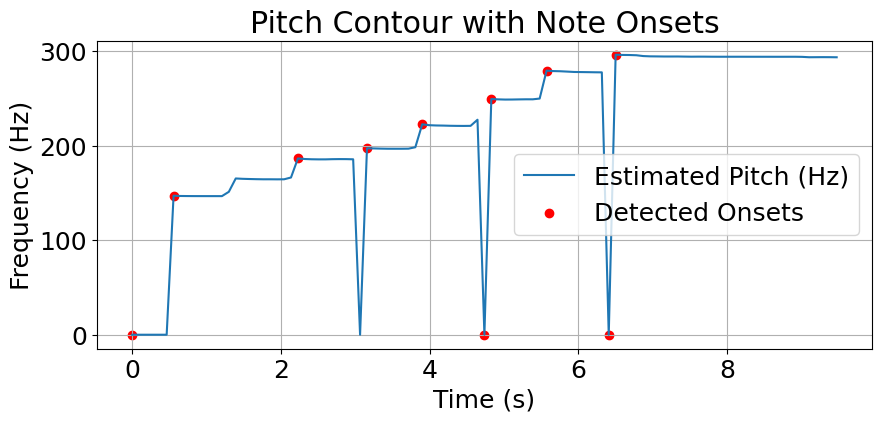

In [34]:
# example with the same file as above

energies = compute_short_time_energy(audio_data, frame_size, hop_size)

# Detect note onsets.
onset_times = detect_note_onsets(pitches, energies, times,
                                 pitch_change_threshold=20,     # adjust as needed
                                 energy_ratio_threshold=2,    # adjust as needed
                                 min_silence_frames=2)

print("Detected note onsets at times (s):", onset_times)

# For visualization, plot the pitch contour and mark onsets.
plt.figure(figsize=(10, 4))
plt.plot(times, pitches, label="Estimated Pitch (Hz)")
plt.scatter(onset_times, [pitches[np.argmin(np.abs(times - t))] for t in onset_times],
            color='red', marker='o', label="Detected Onsets")
plt.title("Pitch Contour with Note Onsets")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.legend()
plt.grid(True)
plt.show()


We can see that this works sometimes, but detects new tones when there is actually only silence. Further, we also see that it does not detect some notes. 

### Discussion

In this project we have looked at two approaches for determening the fundamental frequency. Both are based on discretizing the signal into windows, but take two different approaches. 

Using the Fast Fourier Transform (FFT) method we could look at the frequencies present in a signal. This worked fine for artificial guitar sounds as the spectra took its assumed shape. Therefore, we could use the theory of natural harmonics and overtones to find the best match of the spectra. However, this lead to trouble with a noisy signal that often appears, and one sometimes seeks, in a guitar. Furthermore, the fundamental frequency could also be underrepresented in the spectra while we still percieve it. This is due to the fact that the fundamental period is what we actually percieve. This is due to the coefficients in the infinite fourier sum of the wavefunction. Therefore, it makes more sense to analyze the fundamental period by using the YIN-method.


The YIN algorithm operates in the time domain and works by finding a periodic lag. This lag should minimize the squared difference between each respective signal frame and a delayed copy. This makes it robust against amplitude variations and noisy signals. At the same time this makes it sensitive to a chosen frame size. A too short window will do so we get more datapoints and can detect changes faster, however it gives us a worse resolution in the frequency. It will also do so we can not look at lower frequencies. A too high window will however smear together notes. 

At last we wanted to detect when a new note began. Looking at only the fundamental frequency we can detect when a note is changed, but not if we were to strum the same note twice for instance. We did this by utilizing the short time energy. However this was not succesful as it detected new notes when notes ended and sometimes did not detect new notes. This is probably due to it being a strict requirement not following the natural playing style that one uses on a guitar. It will pick up muting as a note and sliding and hammer-ons will not give a big enough amplitude difference to be registered as a new note. 

In further work, we would like to implement a better detection of new notes. Furthermore, we would like to also detect different techniques as hammer-ons, sliding, pinch harmonics etc. This could however, be a challenge due to the aforementioned nature. We would also like to turn the playing into tabs by looking at where on the guitar the next note most likely will be played. This would also be a challenge as a single note can appear multiple places on the guitar, but often there is a most natural place to play it (unless you are Frank Zappa).

### Conclusion

By implementing FFT and YIN-algorithm, we see that it is possible to analyze and detect the fundamental frequencies of a guitar-recording, finding the YIN-algorithm to outperform in both computational power and accuracy. The YIN-algorithm accurately predicted the fundamental frequency and can also be used for other things than a guitar.

In this project, we did however not manage to determine the playing of a new note by using the short-time energy. In further work we will try utilizing this. 

### Declaration of Use of Generative Artificial Intelligence

In this scientific work, generative artificial intelligence (AI) has been utilized.  
All data and personal information have been handled in accordance with the regulations of the University of Oslo,  
and I, as the author of this document, take full responsibility for its content, claims, and references.

#### Overview of AI usage:
- Generation of LaTeX scripts  
- Spell checking  
- Code debugging  
- Identifying functions and libraries suited to the program’s needs  
- Almost all docstrings and commenting of the code  
- Code optimization, including vectorization and creating dictonaries 
- Generating short code snippets based on pseudocode  
- Naming variables according to conventions  

**Language model used:** OpenAI ChatGPT


### References

- de Cheveigné, A., & Kawahara, H. (2002). *YIN, a fundamental frequency estimator for speech and sounds*. The Journal of the Acoustical Society of America, 111(4).

-  


- Free Wave Samples. (2016, August 4). *Alesis Fusion Clean Guitar C3*. https://freewavesamples.com/alesis-fusion-clean-guitar-c3

- Rabiner, L. R., & Schafer, R. W. (1978). *Digital Processing of Speech Signals* (Chapter 4). Prentice-Hall.

- Vistnes, A. I. (2015). *Physics of Oscillations and Waves*. Springer.

- Wikipedia contributors. (n.d.). *Equal temperament*. Wikipedia. https://en.wikipedia.org/wiki/Equal_temperament (accessed April 8, 2025).
